In [ ]:
  # import numpy as np
  # import pandas as pd
  # import matplotlib.pyplot as plt

  # # import tensorflow as tf
  # from keras.layers import Input, Dense
  # from keras.models import Sequential
  # from keras.layers import Dropout
  # from keras.models import Model

  # import keras
  # from keras.datasets import mnist
  # from keras.datasets import cifar10

  # from tqdm import tqdm_notebook as tqdm
  # # from keras.layers.advanced_activations import LeakyReLU
  # from tensorflow.keras.layers import LeakyReLU


  # from mpl_toolkits import mplot3d
  # from mpl_toolkits.mplot3d import Axes3D
  # import matplotlib.pyplot as plt
  # from matplotlib import cm
  # from matplotlib.ticker import LinearLocator, FormatStrFormatter
  # import numpy as np

  # from numpy import expand_dims
  # from numpy import mean
  # from numpy import ones
  # from numpy.random import randn
  # from numpy.random import randint
  # from keras.datasets.mnist import load_data
  # from keras import backend
  # from keras.optimizers import RMSprop
  # from keras.models import Sequential
  # from keras.layers import Dense
  # from keras.layers import Reshape
  # from keras.layers import Flatten
  # from keras.layers import Conv2D
  # from keras.layers import Conv2DTranspose
  # from keras.layers import LeakyReLU
  # from keras.layers import BatchNormalization
  # from keras.initializers import RandomNormal
  # from keras.constraints import Constraint

  # # from keras.optimizers import Optimizer
  # # from tensorflow.keras import backend
  # from keras.optimizers import Adam, SGD

  # from tqdm.notebook import tqdm
  # from functools import partial
  # from matplotlib.image import imread



  #### ____________MYCODE________________ #####

  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt

  # Keras / TensorFlow imports
  import tensorflow as tf
  tf.config.run_functions_eagerly(True)  # Enable eager execution
  tf.data.experimental.enable_debug_mode()
  from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, Reshape, Flatten, Conv2D, Conv2DTranspose, BatchNormalization
  from tensorflow.keras.models import Model
  from tensorflow.keras.models import Sequential
  # from keras.models import Sequential
  from tensorflow.keras.optimizers import Adam, RMSprop, SGD
  from tensorflow.keras.initializers import RandomNormal
  from tensorflow.keras.constraints import Constraint
  from tensorflow.keras.datasets import mnist, cifar10
  from tensorflow.keras import backend

  # tqdm for progress bars
  from tqdm.notebook import tqdm

  # Matplotlib for plotting
  from mpl_toolkits import mplot3d
  from mpl_toolkits.mplot3d import Axes3D
  from matplotlib import cm
  from matplotlib.ticker import LinearLocator, FormatStrFormatter
  from matplotlib.image import imread

  # NumPy for data manipulation
  from numpy import expand_dims, mean, ones
  from numpy.random import randn, randint

  # Optional: Functionality to load MNIST data
  from tensorflow.keras.datasets.mnist import load_data


  #### ____________________________ #####


  # The Players class defines the two-player game and all necessary update functions
  # x - min player
  # y - max player
  # f - a function of x, y to create new entity z
  # u_x - function to take gradient update step of min player x
  # u_y - function to take gradient update step of max player y
  # c_x - function to change value of x to x_new
  # c_y - function to change value of y to y_new
  # p_x - function to perturb value of x along a random normal direction

  class Players:
      def __init__(self, x, y, f, u_x, u_y, c_x, c_y, p_x):
          self.x = x
          self.y = y
          if f == None:
              self.z = None
          else:
              self.z = f(x, y)
          self.u_x = u_x
          self.u_y = u_y
          self.c_x = c_x
          self.c_y = c_y
          self.p_x = p_x

      def value(self, f):
          return f(self.x, self.y)

      def get_x(self):
          return self.x

      def get_y(self):
          return self.y

      def update_x(self):
          self.x = self.u_x(self.x, self.y, self.z)
          return self.x

      def update_y(self):
          self.y = self.u_y(self.x, self.y, self.z)
          return self.y

      def change_x(self, x_new):
          self.x = self.c_x(self.x, x_new)

      def change_y(self, y_new):
          self.y = self.c_y(self.y, y_new)

      def perturb_x(self):
          self.x = self.p_x(self.x)
          return self.x


  # img = imread('image_digit_1.png')
  # img = img.reshape(400)

  batch_size = 64

  def getGDopt(lr = 0.01):
      lr = float(lr)
      return SGD(lr)

  # Load Mnist data
  def load_data(filter=False, balanced=False):
      (x_train, y_train), (x_test, y_test) = mnist.load_data()
      x_train = (x_train.astype(np.float32) - 127.5)/127.5
      x_train = x_train.reshape(len(x_train), 784)

      x_test = (x_test.astype(np.float32) - 127.5)/127.5
      x_test = x_test.reshape(len(x_test), 784)

      # restricting to digits 0 and 1
      if filter:
          train_filter = np.where((y_train == 0 ) | (y_train == 1))
          x_train, y_train = x_train[train_filter], y_train[train_filter]

          test_filter = np.where((y_test == 0 ) | (y_test == 1))
          x_test, y_test = x_test[test_filter], y_test[test_filter]

      if balanced and filter:
          f = np.where(y_train == 0)
          x_train_0, y_train_0 = x_train[f], y_train[f]
          f = np.where(y_train == 1)
          x_train_1, y_train_1 = x_train[f], y_train[f]

          if len(y_train_1) > len(y_train_0):
              n = len(y_train_0)
          else:
              n = len(y_train_1)

          x_train = np.array(list(x_train_0[:n]) + list(x_train_1[:n]))
          y_train = np.array(list(y_train_0[:n]) + list(y_train_1[:n]))

      return (x_train, y_train, x_test, y_test)

  # (X_train, y_train, X_test, y_test) = load_data()
  # X_train = np.array([img]*128)

  # Create generator network with preferred optimization function
  def create_generator(OUTPUT_SIZE, opt=getGDopt(), INPUT_SIZE=100, loss='binary_crossentropy'):
      generator = Sequential()
      generator.add(Dense(units=256, input_shape=(INPUT_SIZE,)))
      generator.add(LeakyReLU(0.2))

      generator.add(Dense(units=512))
      generator.add(LeakyReLU(0.2))

      generator.add(Dense(units=1024))
      generator.add(LeakyReLU(0.2))

      generator.add(Dense(units=OUTPUT_SIZE, activation='tanh'))

      # Force build the model with dummy input
      dummy_input = np.zeros((1, INPUT_SIZE))
      output = generator(dummy_input)
      print(f"Generator built successfully. Output shape: {output.shape}")

         # Create a new optimizer instance for this specific model
      if opt is None:
          opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

      if loss == 'binary_crossentropy':
          generator.compile(loss='binary_crossentropy', optimizer=opt)
      else:
          generator.compile(loss=wasserstein_loss, optimizer=opt, metrics=['accuracy'])
      return generator

  # Create discriminator network with preferred optimization function
  def create_discriminator(INPUT_SIZE, opt=getGDopt(), loss='binary_crossentropy'):
      discriminator=Sequential()
      discriminator.add(Dense(units=1024,input_shape=(INPUT_SIZE,)))
      discriminator.add(LeakyReLU(0.2))
      discriminator.add(Dropout(0.3))

      discriminator.add(Dense(units=512))
      discriminator.add(LeakyReLU(0.2))
      discriminator.add(Dropout(0.3))

      discriminator.add(Dense(units=256))
      discriminator.add(LeakyReLU(0.2))

      dummy_input = np.zeros((1, INPUT_SIZE))  # Create a dummy batch with one sample
      output = discriminator(dummy_input)  # This builds the model
      print(f"Discriminator built successfully. Output shape: {output.shape}")


      if loss=='binary_crossentropy':
          discriminator.add(Dense(units=1, activation='sigmoid'))
      else:
          discriminator.add(Dense(units=1))

      discriminator.trainable = True

      if opt is None:
          opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

      if loss == 'binary_crossentropy':
          discriminator.compile(loss='binary_crossentropy', optimizer=opt)
      else:
          discriminator.compile(loss=wasserstein_loss, optimizer=opt, metrics=['accuracy'])
      return discriminator

  def create_gan(generator, discriminator, opt=getGDopt(lr=0.01), loss='binary_crossentropy'):
      # The key point here: we need to make a copy of the discriminator
      # Creating a new model to avoid the "never been called" error

        # First, make sure both models are built
      if not hasattr(generator, '_built') or not generator._built:
          dummy_noise = np.zeros((1, generator.input_shape[1]))
          _ = generator(dummy_noise)

      # First, make sure discriminator is built
      if not hasattr(discriminator, '_built') or not discriminator._built:
          dummy_img = np.zeros((1, discriminator.input_shape[1]))
          _ = discriminator(dummy_img)

      # Create the GAN model properly
      gan_input = Input(shape=(generator.input_shape[1],))
      discriminator.trainable = False
      gen_output = generator(gan_input)
      gan_output = discriminator(gen_output)

      # Create and compile the combined model
      gan = Model(inputs=gan_input, outputs=gan_output)

      # Set discriminator non-trainable in this model


      #     # Compile GAN
      # if opt is None:
      #     opt = keras.optimizers.Adam(0.0002, 0.5)
      # gan.compile(loss='binary_crossentropy', optimizer=opt)

          # Use a new optimizer instance
      if opt is None:
          opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)



      if loss == 'binary_crossentropy':
          gan.compile(loss='binary_crossentropy', optimizer=opt)
      else:
          gan.compile(loss=wasserstein_loss, optimizer=opt, metrics=['accuracy'])

      # Call the model once to ensure it's built
      dummy_noise = np.zeros((1, generator.input_shape[1]))
      _ = gan(dummy_noise)
      print("GAN model built successfully")

      return gan

  # gradient update steps for discriminator
  def take_discriminator_steps(generator, discriminator, gan, X_train, k=1, NOISE_SIZE=100):
      for _ in range(k):

          noise= np.random.normal(0,1, [batch_size, NOISE_SIZE])
          generated_images = generator.predict(noise)

          image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]

          X= np.concatenate([image_batch, generated_images])

          y_dis = np.zeros(2*batch_size)
          y_dis[:batch_size] = 1

          discriminator.trainable=True
          loss = discriminator.train_on_batch(X, y_dis)

      return discriminator

  # gradient update steps for discriminator
  def take_discriminator_steps_wgan(generator, discriminator, gan, X_train, k=1, NOISE_SIZE=100, clip=False, clip_value=None):
      for _ in range(k):
          if clip and clip_value is not None:
              for layer in discriminator.layers:
                  weights = layer.get_weights()
                  weights = [np.clip(w, -clip_value, clip_value) for w in weights]
                  layer.set_weights(weights)


          noise= np.random.normal(0,1, [batch_size, NOISE_SIZE])
          generated_images = generator.predict(noise)

          image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]

          X= np.concatenate([image_batch, generated_images])

          y_dis = np.ones(2*batch_size)
          y_dis[:batch_size] = -1

          discriminator.trainable=True
          loss = discriminator.train_on_batch(X, y_dis)
  #         print ("D-loss", loss)

      return discriminator

  # perturbing weights of the generator
  def perturb_generator(generator, sigma=0.001):
      weights, u = [], []
      for wt in generator.get_weights():
          u.append(np.random.normal(0, 1, wt.shape))
          wt = wt + u[-1] * sigma
          weights.append(wt)

      generator.set_weights(weights)

      return generator

  # gradient update steps for generator
  def take_generator_steps(generator, discriminator, gan, NOISE_SIZE=100):
      noise= np.random.normal(0,1, [batch_size, NOISE_SIZE])
      generated_images = generator.predict(noise)

  #     gan = create_gan(discriminator, generator)

      y_gen = np.ones(batch_size)
      discriminator.trainable=False
      loss = gan.train_on_batch(noise, y_gen)
  #     print ("G-loss", loss)

      return generator

  def take_generator_steps_wgan(generator, discriminator, gan, NOISE_SIZE=100):
      noise= np.random.normal(0,1, [batch_size, NOISE_SIZE])
      generated_images = generator.predict(noise)

      y_gen = -np.ones(batch_size)
      discriminator.trainable=False
      loss = gan.train_on_batch(noise, y_gen)
  #     print ("G-loss", loss)

      return generator

  def change_network(modela, modelb):
      modela.set_weights(modelb.get_weights())
      return modela

  def wasserstein_loss(y_true, y_pred):
      return backend.mean(y_true * y_pred)

  def getLoss(generator, discriminator, X_train, NOISE_SIZE=100, eps=0):

      noise= np.random.normal(0,1, [batch_size, NOISE_SIZE])
      image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
      generated_images = generator.predict(noise)

      probabilities_1 = discriminator.predict(image_batch).reshape(len(image_batch))
      probabilities_1 = np.log(probabilities_1 + eps)

      probabilities_2 = discriminator.predict(generated_images).reshape(len(generated_images))
      probabilities_2 = np.log(1 - probabilities_2 + eps)

      return np.mean(probabilities_1) + np.mean(probabilities_2)

  def getWassersteinLoss(generator, discriminator, X_train, NOISE_SIZE=100, eps=0):

      noise= np.random.normal(0,1, [batch_size, NOISE_SIZE])
      image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
      generated_images = generator.predict(noise)

      disc_1 = discriminator.predict(image_batch).reshape(len(image_batch))
      disc_2 = discriminator.predict(generated_images).reshape(len(generated_images))
      y_pred = np.array(list(disc_1) + list(disc_2))
      y_true = np.ones(2*batch_size)
      y_true[:batch_size] = -1

      loss = np.mean(y_true*y_pred)
      return loss

  def getLossFixedBatch(generator, discriminator, image_batch, generated_images):

      probabilities_1 = discriminator.predict(image_batch).reshape(len(image_batch))
      probabilities_1 = np.log(probabilities_1) / np.log(2)

      probabilities_2 = discriminator.predict(generated_images).reshape(len(generated_images))
      probabilities_2 = np.log(1 - probabilities_2) / np.log(2)

      return np.mean(probabilities_1) + np.mean(probabilities_2)


  # Creating a GAN player object
  def create_GAN_player():
      print("HELLO")
      ganPlayer = Players(create_generator(), create_discriminator(), create_gan, take_generator_steps, take_discriminator_steps, change_network, change_network, perturb_generator)
      return ganPlayer


  def plot_generated_images(epoch, generator, folder="", save = False, image_shape=(28,28), examples=100, dim=(10,10), figsize=(10,10),name=""):
      print ("Iteration " + str(epoch))
      noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
      generated_images = generator.predict(noise)
      generated_images = generated_images.reshape(examples,image_shape[0], image_shape[1])
      plt.figure(figsize=figsize)
      for i in range(generated_images.shape[0]):
          plt.subplot(dim[0], dim[1], i+1)
          plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
          plt.axis('off')
      plt.tight_layout()
      plt.show()
      if save:
          plt.savefig(folder+name %epoch)

  ######################################################################


  # select real samples
  def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels, -1 for 'real'
    y = -ones((n_samples, 1))
    return X, y

  # generate points in latent space as input for the generator
  def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

  # use the generator to generate n fake examples, with class labels
  def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels with 1.0 for 'fake'
    y = ones((n_samples, 1))
    return X, y

  # generate samples and save as a plot and save the model
  def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(10 * 10):
      # define subplot
      plt.subplot(10, 10, 1 + i)
      # turn off axis
      plt.axis('off')
      # plot raw pixel data
      plt.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

  # create a line plot of loss for the gan and save to file
  def plot_history(d1_hist, d2_hist, g_hist):
    # plot history
    plt.plot(d1_hist, label='crit_real')
    plt.plot(d2_hist, label='crit_fake')
    plt.plot(g_hist, label='gen')
    plt.legend()
    plt.savefig('plot_line_plot_loss.png')
    plt.close()



In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.optimizers import Adam  # SGD can also be imported from here if needed
from tensorflow.keras import backend as K
import sys
sys.path.append("../")

# from utils_Picky_grayscale import *       # utils file has the filler code and helper functions

from tqdm.notebook import tqdm
from functools import partial
from sklearn.linear_model import LogisticRegression

#set filter = true to include only the digits "0" and "1" in the MNIST dataset
# X, y, X_test, y_test = load_data(filter=True, balanced=False)


X, y, X_test, y_test = load_data()

# from sklearn.linear_model import LogisticRegression
# from sklearn.datasets import fetch_openml
# from sklearn.model_selection import train_test_split

# # Load MNIST dataset (all digits 0-9)
# X, y = fetch_openml('mnist_784', version=1, as_frame=True, parser="pandas").data, fetch_openml('mnist_784', version=1, as_frame=True, parser="pandas").target

# # Optionally, split the data into training and test sets (if not already split)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize and train the Logistic Regression model
# clf = LogisticRegression(random_state=0, max_iter=1000)
# clf.fit(X_train, y_train)

# # Evaluate the model
# accuracy = clf.score(X_test, y_test)
# print(f"Accuracy: {accuracy}")


NOISE_SIZE = 100
IMAGE_SIZE = 784



clf = LogisticRegression(random_state=0, max_iter=1000).fit(X, y)
clf.score(X_test, y_test)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0.9254

In [ ]:

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

take_discriminator_steps_2 = partial(take_discriminator_steps, X_train=X, k=1)
getLoss2 = partial(getLoss, X_train=X)
create_gan2 = partial(create_gan, opt=adam_optimizer)

# The key issue is to create fresh optimizer instances for each model
def create_GAN_player():
    # Create new optimizer instances for each component
    generator_opt = Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator_opt = Adam(learning_rate=0.0002, beta_1=0.5)
    gan_opt = Adam(learning_rate=0.0002, beta_1=0.5)

    # Create generator and discriminator with their own optimizers
    generator = create_generator(OUTPUT_SIZE=IMAGE_SIZE, opt=generator_opt)
    discriminator = create_discriminator(INPUT_SIZE=IMAGE_SIZE, opt=discriminator_opt)

    # Create specialized create_gan function with new optimizer
    create_gan_instance = partial(create_gan, opt=gan_opt)

    # Create partial function for discriminator steps with current X dataset
    take_discriminator_steps_instance = partial(take_discriminator_steps, X_train=X, k=1)

    # Create partial function for loss calculation
    getLoss_instance = partial(getLoss, X_train=X)

    # Create the Players object with all components
    ganPlayer = Players(
        generator,
        discriminator,
        create_gan_instance,
        take_generator_steps,
        take_discriminator_steps_instance,
        change_network,
        change_network,
        perturb_generator
    )

    return ganPlayer


In [ ]:
# def training_gd(create_player_function, create_player_function2, T=3000):
#     #Number of iterations

#     # this will create a Players object, with two players
#     player = create_player_function()
#     player2 = create_player_function2()

#     j = 0
#     losses, ones = [], []
#     player.update_y()

#     for j in tqdm(range(1, T+1)):

#         loss = player.value(getLoss2)
#         losses.append(loss)

#         # perform one gradient update for the generator and one gradient update for the discriminator (we only use "k=1" discriminator gradient steps for MNIST)
#         player.update_x()
#         player.update_y()

#         if j%10 == 0:
#             noise= np.random.normal(loc=0, scale=1, size=[1000, 100])
#             generated_images = player.get_x().predict(noise)
#             ones.append(sum(clf.predict(generated_images))/1000)

#         if j%500 == 0:
#             plot_generated_images(0, player.get_x(), save=False, examples=25, dim=(5,5), figsize=(3,3))

#     return player, losses, ones

from scipy.linalg import sqrtm
from sklearn.metrics import pairwise_distances

# Add functions to calculate FID score and Inception Score (simplified versions for MNIST)

def calculate_fid(real_images, generated_images, feature_extractor=None):
    """
    Calculate Fréchet Inception Distance between real and generated images.
    For MNIST, we'll use a simplified approach without a pre-trained Inception model.

    Args:
        real_images: Sample of real images (normalized between -1 and 1)
        generated_images: Sample of generated images (normalized between -1 and 1)
        feature_extractor: Optional model to extract features (not used in simplified version)

    Returns:
        FID score (lower is better)
    """
    # For MNIST, we'll use flattened image features directly
    # In practice, you'd use a proper feature extractor like Inception

    # Ensure images are properly shaped
    if len(real_images.shape) == 4:  # If images are in 2D format (batch, height, width, channels)
        real_features = real_images.reshape(real_images.shape[0], -1)
        generated_features = generated_images.reshape(generated_images.shape[0], -1)
    else:  # If already flattened
        real_features = real_images
        generated_features = generated_images

    # Calculate mean and covariance for both distributions
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)

    # Calculate squared difference between means
    diff = mu1 - mu2

    # Calculate sqrt of product of covariances
    # Add small epsilon to avoid numerical issues
    covmean = sqrtm(sigma1.dot(sigma2) + 1e-6)

    # Check and correct imaginary component if necessary
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate FID
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)

    return fid

def calculate_inception_score(generated_images, clf, n_split=10):
    """
    Calculate Inception Score using a classifier (simplified for MNIST).

    Args:
        generated_images: Sample of generated images
        clf: Classifier model that predicts class probabilities
        n_split: Number of splits for calculating IS

    Returns:
        Inception Score (higher is better)
    """
    # Get predictions using the classifier
    probs = clf.predict_proba(generated_images)

    # Calculate IS score
    # Split images into n_split groups
    n_samples = generated_images.shape[0]
    split_size = n_samples // n_split
    scores = []

    for i in range(n_split):
        start = i * split_size
        end = start + split_size
        part = probs[start:end]

        # Calculate KL divergence
        p_y = np.mean(part, axis=0, keepdims=True)
        kl = part * (np.log(part + 1e-10) - np.log(p_y + 1e-10))
        kl = np.mean(np.sum(kl, axis=1))
        scores.append(np.exp(kl))

    # Return mean and standard deviation
    return np.mean(scores), np.std(scores)









# # Updated training function that properly handles multiple player creation
# def training_gd(create_player_function, T=3000):
#     # Create a fresh Players object
#     player = create_player_function()

#     j = 0
#     losses, ones = [], []

#     # Initial update to the discriminator
#     player.update_y()

#     for j in tqdm(range(1, T+1)):
#         # Calculate current loss
#         getLoss_instance = partial(getLoss, X_train=X)
#         loss = player.value(getLoss_instance)
#         losses.append(loss)

#         # Perform gradient updates
#         player.update_x()  # Update generator
#         player.update_y()  # Update discriminator

#         # Periodically check classifier performance on generated images
#         if j % 10 == 0:
#             noise = np.random.normal(loc=0, scale=1, size=[1000, 100])
#             generated_images = player.get_x().predict(noise)
#             ones.append(sum(clf.predict(generated_images)) / 1000)

#         # Periodically visualize results
#         if j % 500 == 0:
#             plot_generated_images(0, player.get_x(), save=False, examples=25, dim=(5,5), figsize=(3,3))

#     return player, losses, ones

# Updated training function that properly handles multiple player creation
def training_gd(create_player_function, T=3000):
    # Create a fresh Players object
    player = create_player_function()

    j = 0
    losses = []
    ones = []
    fid_scores = []
    is_scores = []
    gen_losses = []
    disc_losses = []

    # Initial update to the discriminator
    player.update_y()

    # Get a fixed batch of real images for consistent FID calculation
    real_sample_indices = np.random.randint(0, len(X), 1000)
    real_samples = X[real_sample_indices]

    for j in tqdm(range(1, T+1)):
        # Calculate current loss
        getLoss_instance = partial(getLoss, X_train=X)
        loss = player.value(getLoss_instance)
        losses.append(loss)

        # Record generator and discriminator losses separately
        noise_batch = np.random.normal(0, 1, [batch_size, NOISE_SIZE])
        generated_batch = player.get_x().predict(noise_batch)

        # Discriminator loss
        X_batch = np.concatenate([
            X[np.random.randint(0, len(X), batch_size)],
            generated_batch
        ])
        y_disc = np.zeros(2*batch_size)
        y_disc[:batch_size] = 1

        disc_loss = player.get_y().test_on_batch(X_batch, y_disc)
        disc_losses.append(disc_loss)

        # Generator loss
        y_gen = np.ones(batch_size)
        gan = create_gan(player.get_x(), player.get_y(), opt=Adam(learning_rate=0.0002, beta_1=0.5))
        gen_loss = gan.test_on_batch(noise_batch, y_gen)
        gen_losses.append(gen_loss)

        # Perform gradient updates
        player.update_x()  # Update generator
        player.update_y()  # Update discriminator

        # Periodically check metrics
        if j % 100 == 0 or j == 1:
            # Generate images for evaluation
            noise = np.random.normal(loc=0, scale=1, size=[1000, 100])
            generated_images = player.get_x().predict(noise)

            # Calculate classifier performance
            ones_ratio = sum(clf.predict(generated_images)) / 1000
            ones.append(ones_ratio)

            # Calculate FID score
            fid = calculate_fid(real_samples, generated_images)
            fid_scores.append(fid)

            # Calculate Inception Score if classifier has predict_proba method
            if hasattr(clf, 'predict_proba'):
                is_score, _ = calculate_inception_score(generated_images, clf)
                is_scores.append(is_score)
            else:
                is_scores.append(0)  # Default if not available

            # Print current metrics
            print(f"\nIteration {j}/{T}")
            print(f"Generator Loss: {gen_losses[-1]:.4f}")
            print(f"Discriminator Loss: {disc_losses[-1]:.4f}")
            print(f"FID Score: {fid:.4f}")
            if hasattr(clf, 'predict_proba'):
                print(f"Inception Score: {is_scores[-1]:.4f}")
            print(f"Ones Ratio: {ones_ratio:.4f}")

            # Generate and display sample images
            plot_generated_images(j, player.get_x(), save=False, examples=25, dim=(5,5), figsize=(3,3))

    # Return all tracked metrics
    metrics = {
        'losses': losses,
        'ones': ones,
        'fid_scores': fid_scores,
        'is_scores': is_scores,
        'gen_losses': gen_losses,
        'disc_losses': disc_losses
    }

    return player, metrics

Starting training run 1/5
Generator built successfully. Output shape: (1, 784)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Discriminator built successfully. Output shape: (1, 256)
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 


  0%|          | 0/10000 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 1/10000
Generator Loss: 0.6656
Discriminator Loss: 0.4676
FID Score: 702.3634
Inception Score: 1.7442
Ones Ratio: 0.0050
Iteration 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


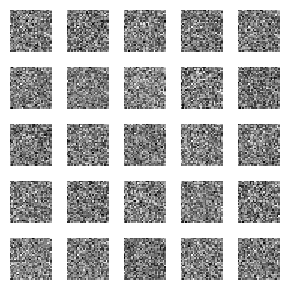

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 100/10000
Generator Loss: 1.3163
Discriminator Loss: 0.4612
FID Score: 343.6575
Inception Score: 1.2317
Ones Ratio: 0.1730
Iteration 100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


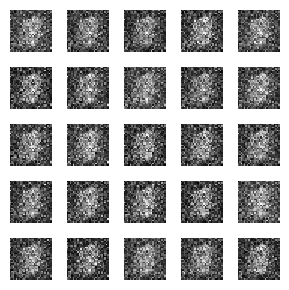

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 200/10000
Generator Loss: 1.4226
Discriminator Loss: 0.4399
FID Score: 390.1980
Inception Score: 1.3395
Ones Ratio: 0.0970
Iteration 200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


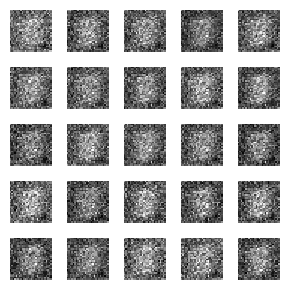

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 300/10000
Generator Loss: 1.4094
Discriminator Loss: 0.3841
FID Score: 351.8733
Inception Score: 1.8529
Ones Ratio: 0.0230
Iteration 300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


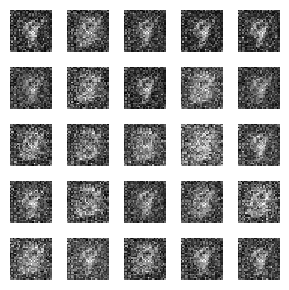

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 400/10000
Generator Loss: 1.8837
Discriminator Loss: 0.3685
FID Score: 248.0619
Inception Score: 3.2342
Ones Ratio: 0.0710
Iteration 400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


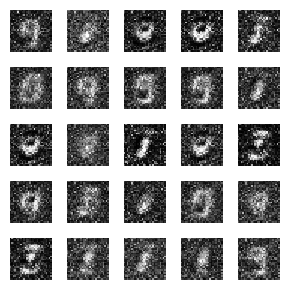

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 500/10000
Generator Loss: 1.2860
Discriminator Loss: 0.3606
FID Score: 208.5186
Inception Score: 2.6859
Ones Ratio: 0.0740
Iteration 500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


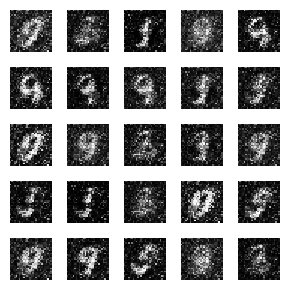

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 600/10000
Generator Loss: 0.8498
Discriminator Loss: 0.3517
FID Score: 230.4874
Inception Score: 3.6383
Ones Ratio: 0.1510
Iteration 600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


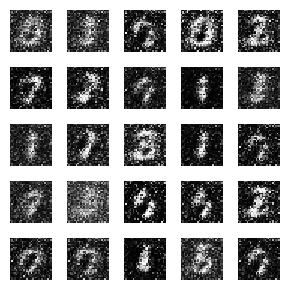

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 700/10000
Generator Loss: 3.7457
Discriminator Loss: 0.3550
FID Score: 185.3328
Inception Score: 3.6906
Ones Ratio: 0.1660
Iteration 700
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


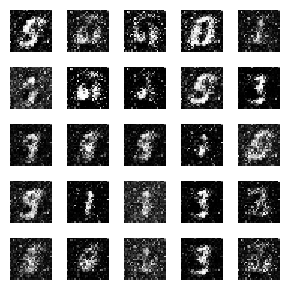

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 800/10000
Generator Loss: 2.0157
Discriminator Loss: 0.3519
FID Score: 198.9291
Inception Score: 3.8030
Ones Ratio: 0.1330
Iteration 800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


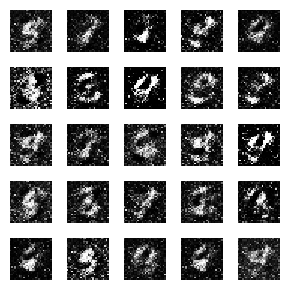

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 900/10000
Generator Loss: 1.9512
Discriminator Loss: 0.3506
FID Score: 147.4072
Inception Score: 3.9730
Ones Ratio: 0.2150
Iteration 900
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


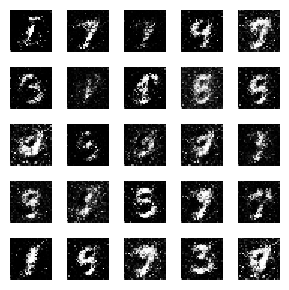

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 1000/10000
Generator Loss: 0.9834
Discriminator Loss: 0.3479
FID Score: 168.7818
Inception Score: 3.9300
Ones Ratio: 0.1290
Iteration 1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


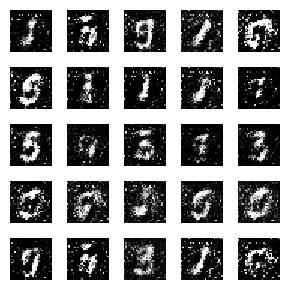

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 1100/10000
Generator Loss: 2.1884
Discriminator Loss: 0.3441
FID Score: 161.5908
Inception Score: 4.6278
Ones Ratio: 0.1090
Iteration 1100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


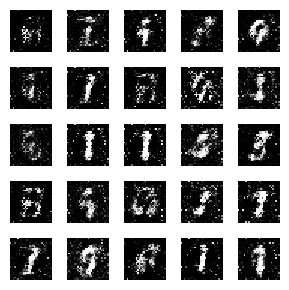

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 1200/10000
Generator Loss: 2.0168
Discriminator Loss: 0.3420
FID Score: 137.1029
Inception Score: 3.6665
Ones Ratio: 0.2300
Iteration 1200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


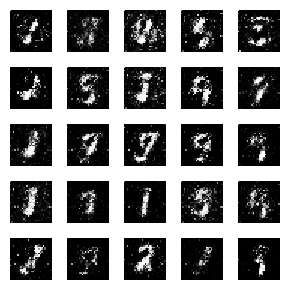

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 1300/10000
Generator Loss: 1.8684
Discriminator Loss: 0.3401
FID Score: 148.7515
Inception Score: 4.6472
Ones Ratio: 0.0280
Iteration 1300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


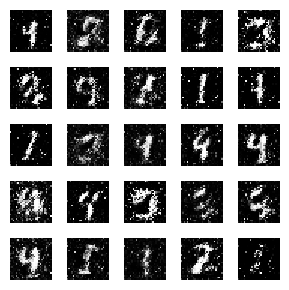

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 1400/10000
Generator Loss: 2.1684
Discriminator Loss: 0.3414
FID Score: 130.3612
Inception Score: 4.9217
Ones Ratio: 0.1330
Iteration 1400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


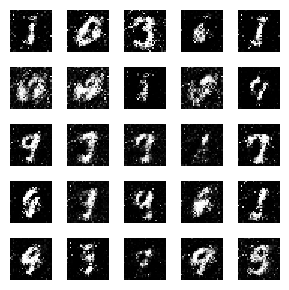

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 1500/10000
Generator Loss: 1.9574
Discriminator Loss: 0.3421
FID Score: 115.8163
Inception Score: 4.8288
Ones Ratio: 0.1140
Iteration 1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


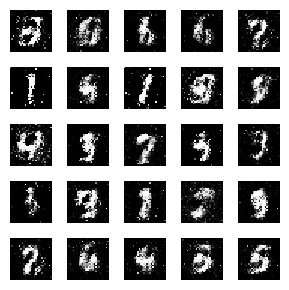

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 1600/10000
Generator Loss: 2.6665
Discriminator Loss: 0.3422
FID Score: 119.6275
Inception Score: 4.7683
Ones Ratio: 0.0350
Iteration 1600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


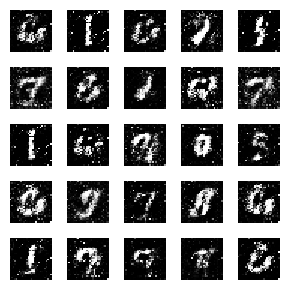

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 1700/10000
Generator Loss: 2.1782
Discriminator Loss: 0.3431
FID Score: 131.5080
Inception Score: 4.2431
Ones Ratio: 0.0690
Iteration 1700
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


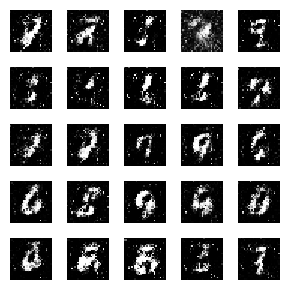

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 1800/10000
Generator Loss: 1.4519
Discriminator Loss: 0.3427
FID Score: 128.6157
Inception Score: 4.6465
Ones Ratio: 0.1060
Iteration 1800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


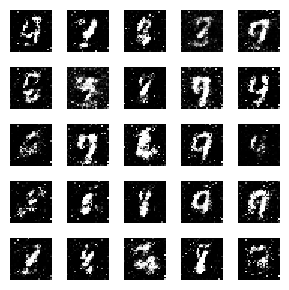

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 1900/10000
Generator Loss: 1.6425
Discriminator Loss: 0.3437
FID Score: 108.1737
Inception Score: 5.1202
Ones Ratio: 0.0880
Iteration 1900
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


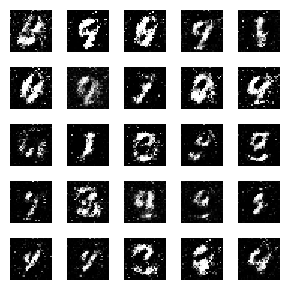

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 2000/10000
Generator Loss: 1.7114
Discriminator Loss: 0.3441
FID Score: 111.7689
Inception Score: 5.1598
Ones Ratio: 0.1750
Iteration 2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


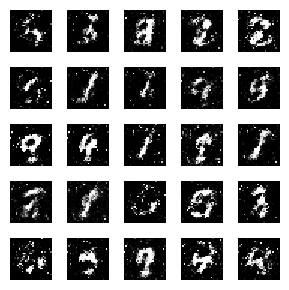

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 2100/10000
Generator Loss: 3.1403
Discriminator Loss: 0.3439
FID Score: 128.0513
Inception Score: 4.5474
Ones Ratio: 0.0340
Iteration 2100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


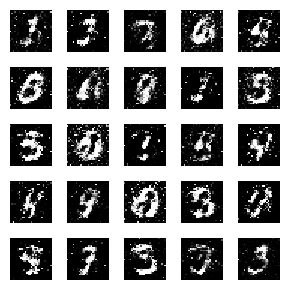

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 2200/10000
Generator Loss: 2.1831
Discriminator Loss: 0.3435
FID Score: 111.7152
Inception Score: 4.9372
Ones Ratio: 0.0200
Iteration 2200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


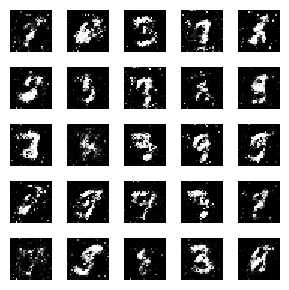

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 2300/10000
Generator Loss: 2.6016
Discriminator Loss: 0.3439
FID Score: 110.9248
Inception Score: 5.1444
Ones Ratio: 0.1310
Iteration 2300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


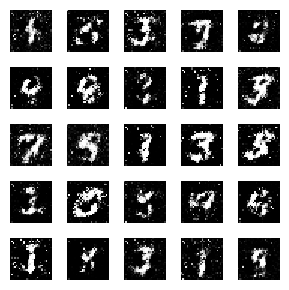

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 2400/10000
Generator Loss: 1.9966
Discriminator Loss: 0.3443
FID Score: 105.9545
Inception Score: 4.8923
Ones Ratio: 0.1450
Iteration 2400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


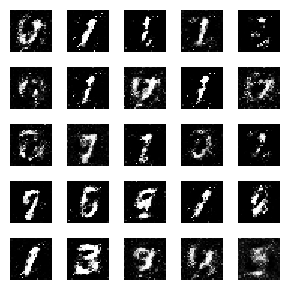

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 2500/10000
Generator Loss: 2.5615
Discriminator Loss: 0.3443
FID Score: 101.2258
Inception Score: 5.2298
Ones Ratio: 0.1590
Iteration 2500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


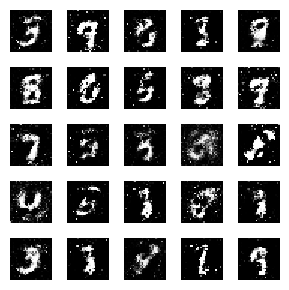

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 2600/10000
Generator Loss: 2.0517
Discriminator Loss: 0.3449
FID Score: 103.5737
Inception Score: 4.8663
Ones Ratio: 0.2070
Iteration 2600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


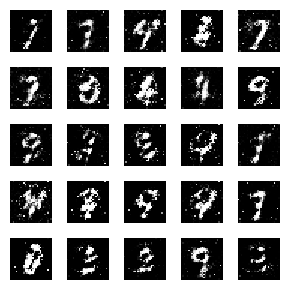

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 2700/10000
Generator Loss: 1.5950
Discriminator Loss: 0.3456
FID Score: 94.0472
Inception Score: 4.4050
Ones Ratio: 0.1330
Iteration 2700
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


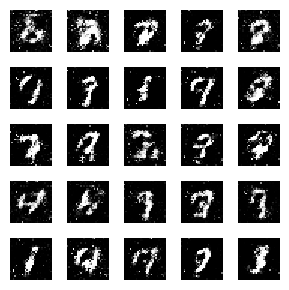

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 2800/10000
Generator Loss: 2.1068
Discriminator Loss: 0.3471
FID Score: 89.8481
Inception Score: 5.1134
Ones Ratio: 0.0430
Iteration 2800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


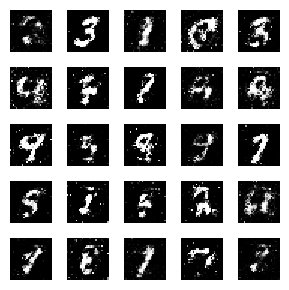

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 2900/10000
Generator Loss: 1.9872
Discriminator Loss: 0.3482
FID Score: 103.5753
Inception Score: 5.0528
Ones Ratio: 0.0900
Iteration 2900
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


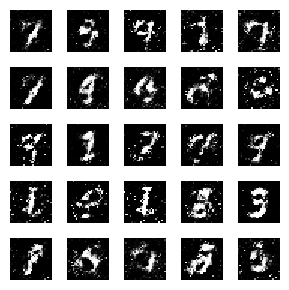

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 3000/10000
Generator Loss: 2.0900
Discriminator Loss: 0.3492
FID Score: 90.5041
Inception Score: 4.8322
Ones Ratio: 0.1630
Iteration 3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


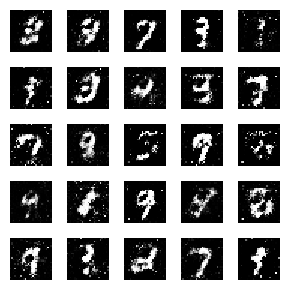

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 3100/10000
Generator Loss: 2.4065
Discriminator Loss: 0.3502
FID Score: 87.4594
Inception Score: 5.0932
Ones Ratio: 0.2360
Iteration 3100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


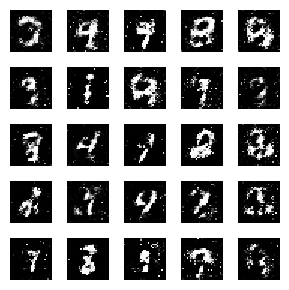

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 3200/10000
Generator Loss: 1.7593
Discriminator Loss: 0.3518
FID Score: 80.3808
Inception Score: 5.2630
Ones Ratio: 0.2050
Iteration 3200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


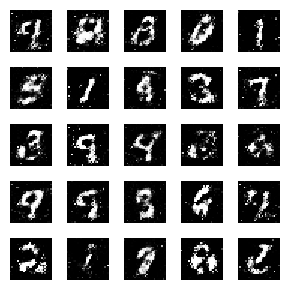

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 3300/10000
Generator Loss: 2.1501
Discriminator Loss: 0.3529
FID Score: 77.1654
Inception Score: 5.1865
Ones Ratio: 0.1560
Iteration 3300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


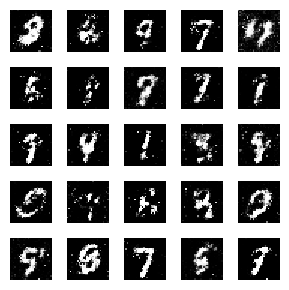

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 3400/10000
Generator Loss: 1.1437
Discriminator Loss: 0.3550
FID Score: 79.7993
Inception Score: 4.9914
Ones Ratio: 0.2280
Iteration 3400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


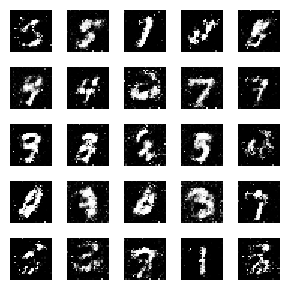

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 3500/10000
Generator Loss: 1.7490
Discriminator Loss: 0.3571
FID Score: 80.8456
Inception Score: 5.1172
Ones Ratio: 0.0680
Iteration 3500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


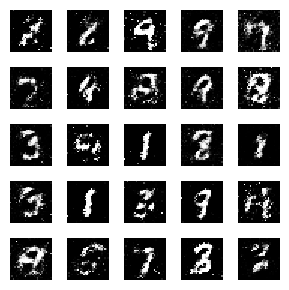

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 3600/10000
Generator Loss: 1.1063
Discriminator Loss: 0.3594
FID Score: 73.3409
Inception Score: 5.1631
Ones Ratio: 0.2280
Iteration 3600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


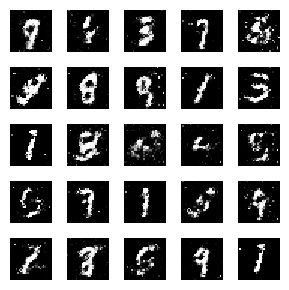

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 3700/10000
Generator Loss: 1.6054
Discriminator Loss: 0.3620
FID Score: 76.2144
Inception Score: 4.9386
Ones Ratio: 0.1860
Iteration 3700
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


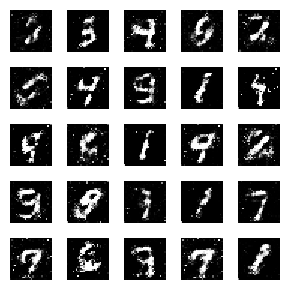

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 3800/10000
Generator Loss: 1.6234
Discriminator Loss: 0.3648
FID Score: 72.2401
Inception Score: 5.4307
Ones Ratio: 0.0510
Iteration 3800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


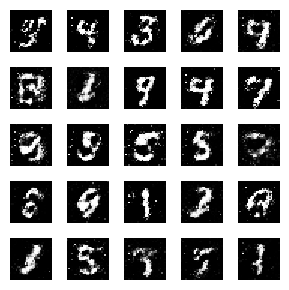

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 3900/10000
Generator Loss: 1.5765
Discriminator Loss: 0.3673
FID Score: 70.0158
Inception Score: 5.5928
Ones Ratio: 0.1130
Iteration 3900
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


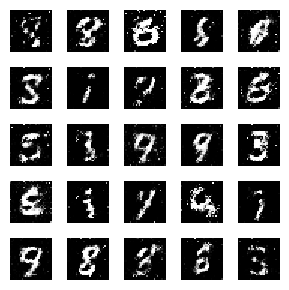

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 4000/10000
Generator Loss: 1.4753
Discriminator Loss: 0.3704
FID Score: 63.6353
Inception Score: 5.5073
Ones Ratio: 0.0710
Iteration 4000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


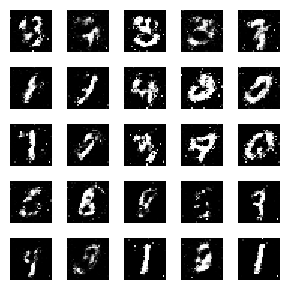

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 4100/10000
Generator Loss: 1.4585
Discriminator Loss: 0.3734
FID Score: 63.3603
Inception Score: 5.5047
Ones Ratio: 0.1280
Iteration 4100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


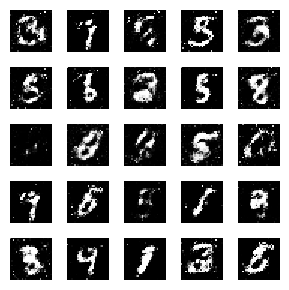

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 4200/10000
Generator Loss: 1.2920
Discriminator Loss: 0.3762
FID Score: 62.9056
Inception Score: 5.2531
Ones Ratio: 0.1250
Iteration 4200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


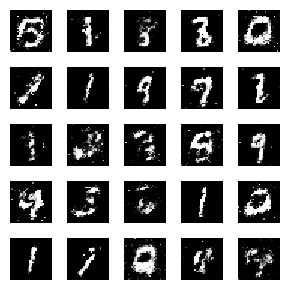

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 4300/10000
Generator Loss: 1.2488
Discriminator Loss: 0.3792
FID Score: 62.0616
Inception Score: 5.7031
Ones Ratio: 0.2480
Iteration 4300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


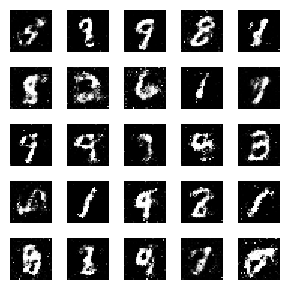

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 4400/10000
Generator Loss: 1.2817
Discriminator Loss: 0.3823
FID Score: 63.4954
Inception Score: 5.7168
Ones Ratio: 0.1540
Iteration 4400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


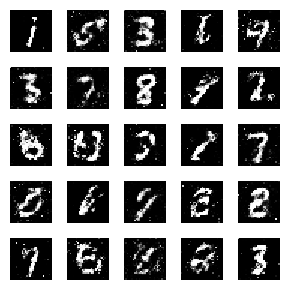

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 4500/10000
Generator Loss: 1.4631
Discriminator Loss: 0.3854
FID Score: 55.8582
Inception Score: 5.6319
Ones Ratio: 0.0160
Iteration 4500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


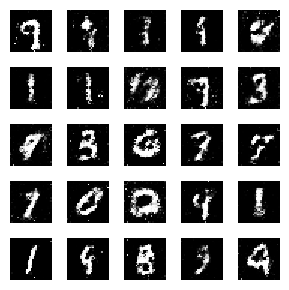

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 4600/10000
Generator Loss: 1.1127
Discriminator Loss: 0.3884
FID Score: 55.2551
Inception Score: 5.8028
Ones Ratio: 0.0570
Iteration 4600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


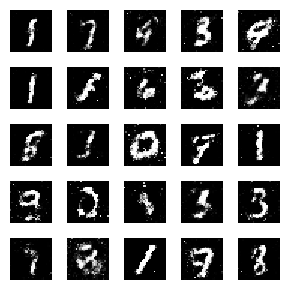

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 4700/10000
Generator Loss: 1.2550
Discriminator Loss: 0.3914
FID Score: 56.1139
Inception Score: 5.9548
Ones Ratio: 0.1290
Iteration 4700
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


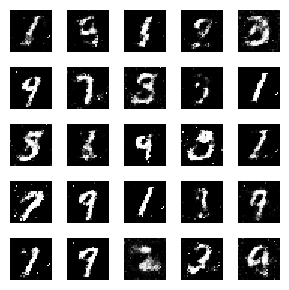

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 4800/10000
Generator Loss: 1.1281
Discriminator Loss: 0.3941
FID Score: 54.1357
Inception Score: 5.6523
Ones Ratio: 0.1430
Iteration 4800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


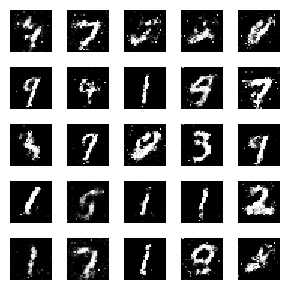

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 4900/10000
Generator Loss: 1.1738
Discriminator Loss: 0.3968
FID Score: 53.6480
Inception Score: 5.9427
Ones Ratio: 0.2440
Iteration 4900
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


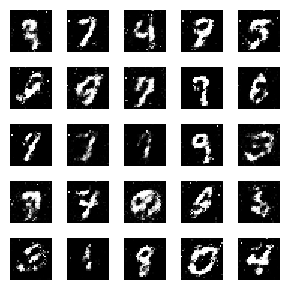

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 5000/10000
Generator Loss: 1.7754
Discriminator Loss: 0.3993
FID Score: 58.0119
Inception Score: 5.9014
Ones Ratio: 0.0890
Iteration 5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


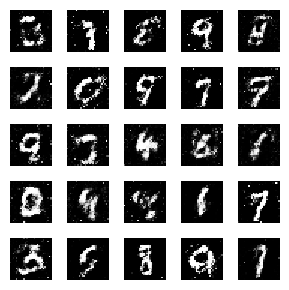

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 5100/10000
Generator Loss: 1.2534
Discriminator Loss: 0.4019
FID Score: 50.2597
Inception Score: 5.9599
Ones Ratio: 0.1480
Iteration 5100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


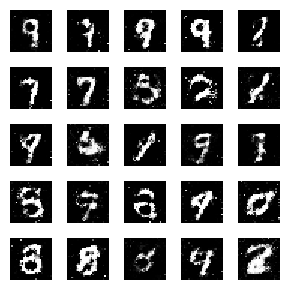

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 5200/10000
Generator Loss: 1.2812
Discriminator Loss: 0.4045
FID Score: 55.0108
Inception Score: 5.8584
Ones Ratio: 0.0760
Iteration 5200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


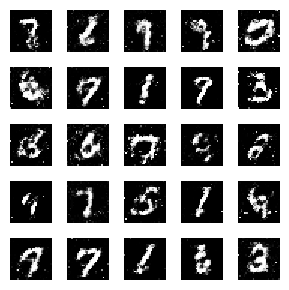

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 5300/10000
Generator Loss: 1.2868
Discriminator Loss: 0.4068
FID Score: 53.5320
Inception Score: 6.0320
Ones Ratio: 0.0520
Iteration 5300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


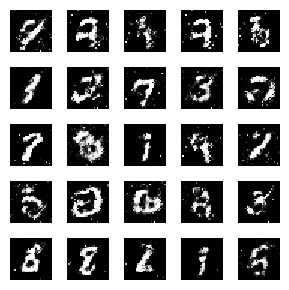

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000



Iteration 5400/10000
Generator Loss: 1.3817
Discriminator Loss: 0.4092
FID Score: 51.6893
Inception Score: 5.9535
Ones Ratio: 0.0960
Iteration 5400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


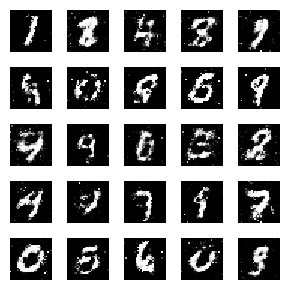

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GAN model built successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━

<ipython-input-8-191d9f1fdc1f>:214: RuntimeWarning: overflow encountered in scalar add
  ones_ratio = sum(clf.predict(generated_images)) / 1000


In [ ]:


# reps = 5
# ones_gda = []

# for _ in range(reps):
#     K.clear_session()
#     adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
#     take_discriminator_steps_2 = partial(take_discriminator_steps, X_train=X, k=1)
#     getLoss2 = partial(getLoss, X_train=X)
#     create_gan2 = partial(create_gan, opt=adam_optimizer)

#     ganPlayerGD, losses, ones = training_gd(create_GAN_player, create_GAN_player, T=10000)
#     ones_gda.append(list(ones))

# Run the training with multiple repetitions
# def run_training(reps=5, training_steps=10000):
#     all_ones = []

#     for i in range(reps):
#         # Clear the Keras session to free memory and reset models
#         K.clear_session()
#         print(f"Starting training run {i+1}/{reps}")
#         player, losses, ones = training_gd(create_GAN_player, T=training_steps)
#         all_ones.append(list(ones))
#         print(f"Completed training run {i+1}/{reps}")

#     return all_ones

# # Run the training
# ones_gda = run_training(reps=5, training_steps=10000)




# Run the training with multiple repetitions
def run_training(reps=5, training_steps=10000):
    all_metrics = []

    for i in range(reps):
        # Clear the Keras session to free memory and reset models
        K.clear_session()

        print(f"Starting training run {i+1}/{reps}")
        player, metrics = training_gd(create_GAN_player, T=training_steps)
        all_metrics.append(metrics)
        print(f"Completed training run {i+1}/{reps}")

        # Print final metrics for this run
        print(f"\nFinal metrics for run {i+1}:")
        print(f"Final Generator Loss: {metrics['gen_losses'][-1]:.4f}")
        print(f"Final Discriminator Loss: {metrics['disc_losses'][-1]:.4f}")
        print(f"Final FID Score: {metrics['fid_scores'][-1]:.4f}")
        if metrics['is_scores'][-1] > 0:
            print(f"Final Inception Score: {metrics['is_scores'][-1]:.4f}")
        print(f"Final Ones Ratio: {metrics['ones'][-1]:.4f}")

    return all_metrics

# Run the training
metrics_gda = run_training(reps=5, training_steps=10000)

# Plot the progression of metrics over training
def plot_metrics(all_metrics):
    metrics_names = ['Generator Loss', 'Discriminator Loss', 'FID Score', 'Inception Score', 'Ones Ratio']
    metrics_keys = ['gen_losses', 'disc_losses', 'fid_scores', 'is_scores', 'ones']

    plt.figure(figsize=(15, 10))

    for i, (name, key) in enumerate(zip(metrics_names, metrics_keys)):
        plt.subplot(2, 3, i+1)
        for run_idx, metrics in enumerate(all_metrics):
            values = metrics[key]
            iterations = np.linspace(0, 10000, len(values))
            plt.plot(iterations, values, label=f'Run {run_idx+1}')

        plt.title(name)
        plt.xlabel('Iterations')
        plt.ylabel('Value')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the metrics
plot_metrics(metrics_gda)

